# Load Data

In [209]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [210]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [211]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [212]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 6
    train_folds = 0 # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet18.a1_in1k"
    epochs = 1
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 50
    frozen_layers = 0

In [192]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

In [213]:
device = torch.device(CFG.device)

# Load train data

In [214]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv')).sample(frac=1).reset_index(drop=True)
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,26662,26677,33758_right,0
1,7164,7168,8975_left,0
2,18322,18334,23094_left,0
3,3687,3691,4620_right,3
4,16007,16017,20089_right,0
...,...,...,...,...
35103,13077,13086,16446_left,0
35104,16733,16743,21015_right,0
35105,7884,7890,9897_left,0
35106,8235,8241,10320_right,1


In [215]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [216]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [217]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
train_data.level.value_counts()

level
0    50
3    50
2    50
1    50
4    50
Name: count, dtype: int64

# Dataset

In [218]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [223]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    CustomTransform(),
    v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    v2.RandomApply([v2.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    # v2.RandomGrayscale(p=0.2),
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [224]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

In [225]:
class ContrastiveLearningDataset(Dataset):
    def __init__(self, folder, data, transform=None):
        self.folder = folder
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.folder}{self.data.loc[idx, 'image']}.jpeg"
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)  # Apply the same transform twice
        else:
            xi = xj = image

        return xi, xj

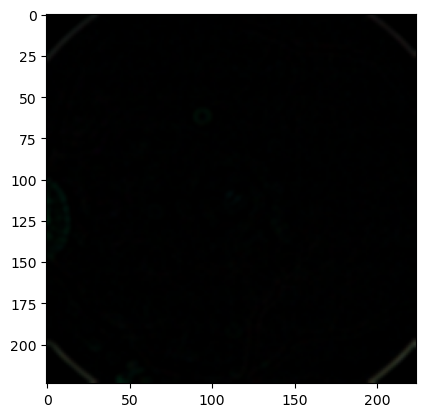

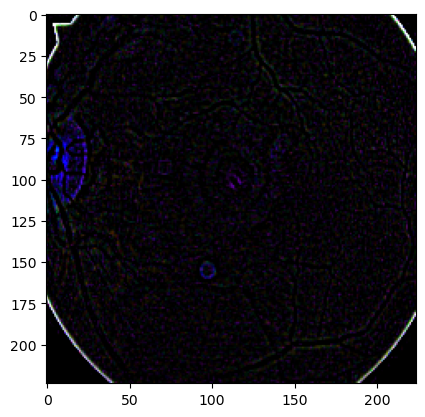

In [226]:
# visualize the transformations
train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
img1, img2 = train_dataset[10]
transformed_img_pil = func.to_pil_image(img1)
plt.imshow(transformed_img_pil)
plt.show()

transformed_img_pil_2 = func.to_pil_image(img2)
plt.imshow(transformed_img_pil_2)
plt.show()

# Metric

In [ ]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

In [ ]:
# Loss Function (NT-Xent Loss)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)
        sim_matrix = torch.exp(torch.mm(z, z.t().contiguous()) / self.temperature)
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        sim_matrix = sim_matrix.masked_fill(mask, 0)
        positives = torch.exp(torch.sum(z_i * z_j, dim=-1) / self.temperature)
        positives = torch.cat([positives, positives], dim=0)
        loss = self.criterion(sim_matrix, positives)
        return loss

# Train and evaluate functions

In [ ]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [177]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [178]:
def evaluate_model(cfg, model, data_loader, device, epoch=-1):
    criterion = torch.nn.BCEWithLogitsLoss()  # Assuming binary classification
    model.eval()

    val_loss = 0
    total_len = len(data_loader)
    correct = 0

    targets = []
    outputs_collect = []

    tk0 = tqdm(enumerate(data_loader), total=total_len)

    with torch.no_grad():
        for step, (images_1, images_2, labels) in tk0:
            images_1, images_2, labels = images_1.to(device), images_2.to(device), labels.to(device)

            outputs = model(images_1, images_2).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = torch.where(outputs > 0, 1, 0)  # Get binary predictions
            correct += predicted.eq(labels.view_as(predicted)).sum().item()

            targets.append(labels.detach().cpu())
            outputs_collect.append(outputs.detach().cpu())

    val_loss /= total_len
    total_targets = torch.cat(targets, dim=0)
    total_outputs = torch.cat(outputs_collect, dim=0)

    probabilities = torch.sigmoid(total_outputs)  # Convert logits to probabilities

    try:
        roc_auc = roc_auc_score(total_targets.numpy(), probabilities.numpy())
    except ValueError:
        roc_auc = 0

    accuracy = accuracy_score(total_targets.numpy(), (probabilities > 0.5).numpy())
    precision = precision_score(total_targets.numpy(), (probabilities > 0.5).numpy(), average='weighted')

    print(f'\nEpoch {epoch}: Validation loss: {val_loss:.4f}, AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}')
    return val_loss, roc_auc, accuracy, precision

In [179]:
def train_epoch(cfg, feature_extractor, projection_head, train_loader, loss_fn, device, optimizer, scheduler, epoch):  
    feature_extractor.train()
    projection_head.train()

    train_loss = 0
    learning_rate_history = []
    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)

    for step, (xi, xj) in tk0:
        xi, xj = xi.to(device), xj.to(device)
        
        optimizer.zero_grad()
        
        zi = projection_head(feature_extractor(xi))
        zj = projection_head(feature_extractor(xj))
        
        loss = loss_fn(zi, zj)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Update learning rate scheduler if present
        if scheduler is not None:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimizer.param_groups[0]['lr']
        
        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

    train_loss /= total_len

    print(f'Epoch {epoch}: training loss = {train_loss:.4f}')
    return train_loss, learning_rate_history

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='level', ylabel='Count'>

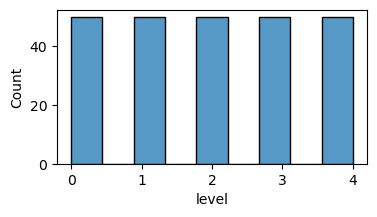

In [180]:
plt.figure(figsize=(4,2))
sns.histplot(train_data["level"])

In [182]:
def create_model():
    model = timm.create_model(CFG.model_name, num_classes=0, pretrained=True)
    # freeze_initial_layers(model, freeze_up_to_layer=CFG.frozen_layers)
    return model.to(device)

In [ ]:
# Define the projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [183]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()

    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # store the embeddings for future use
    torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


def plot_tsne(embeddings, labels):
    # Apply t-SNE to the embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings.numpy())

    # Define the number of unique labels/classes
    num_classes = len(np.unique(labels.numpy()))
    # Create a custom color map with specific color transitions
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=num_classes)

    # Create a boundary norm with boundaries and colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 0.5, 1), cmap.N)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
    colorbar.set_label('Severity Level')
    colorbar.set_ticklabels(np.arange(num_classes))  # Set discrete labels if needed
    plt.title('t-SNE of Image Embeddings with Discrete Severity Levels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.savefig(os.path.join(wandb.run.dir, f"tsne.png"), dpi=300, bbox_inches='tight')


## Train folds

In [185]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image"].values, train_data["level"].values)):
    train_data.loc[test_index, "fold"] = i

In [ ]:
for FOLD in CFG.train_folds:
    seed_everything(CFG.seed)

    # Prepare datasets and data loaders
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, fold_train_data, transforms=train_transforms)
    valid_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )

    # Prepare model, optimizer, and scheduler
    model = create_model()
    projection_head = ProjectionHead(input_dim=model.fc.in_features, output_dim=128).to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(projection_head.parameters()), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    best_score = 0

    wandb.run.tags = [f"fold_{FOLD}"]

    for epoch in range(CFG.epochs):
        train_loss, train_lr, train_auc, train_accuracy, train_precision = train_epoch(
            CFG, model, projection_head, train_loader, device, optimizer, scheduler, epoch
        )

        val_loss, val_auc, val_accuracy, val_precision = evaluate_model(
            CFG, model, projection_head, valid_loader, device, epoch
        )

        if val_accuracy > best_score:
            print(f"New best score: {best_score:.4f} -> {val_accuracy:.4f}")
            best_score = val_accuracy
            model_path = os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth')
            torch.save(model.state_dict(), model_path)
            wandb.save(model_path)

        scheduler.step()  # Update the learning rate scheduler at the end of each epoch

    wandb.finish()

            
    # plot a tsne plot of all the images using embeddings from the model
    full_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transforms=val_transforms)
    loader = DataLoader(
        full_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )
    
    features, targets = get_embeddings(model, loader)
    plot_tsne(features, targets)

In [157]:
wandb.finish()